In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# read data from binary files

data_0 = np.fromfile('222a_50V_board_0.bin', dtype = 'uint32')
data_1 = np.fromfile('222a_50V_board_1.bin', dtype = 'uint32')

In [5]:
# The data is in the format of 4 bytes header + 12 channels * 1000 samples

record_length = 1000
channels = 12
headersize = 4
size_event = int(headersize+channels*record_length/2)
event_N0 = int(len(data_0)/size_event)
event_N1 = int(len(data_1)/size_event)

print(len(data_0)/size_event)
print(len(data_1)/size_event)


data_0_formatted = data_0.reshape(event_N0, size_event)
data_1_formatted = data_1.reshape(event_N1, size_event)

data_0_headers = data_0_formatted[:,:4]
data_1_headers = data_1_formatted[:,:4]

events_1 = data_1_formatted[:, headersize:].reshape(event_N1,channels,int(record_length/2))&0xFFFF
events_0 = data_0_formatted[:, headersize:].reshape(event_N0,channels,int(record_length/2))&0xFFFF
events_0.shape

99726.0
100278.0


(99726, 12, 500)

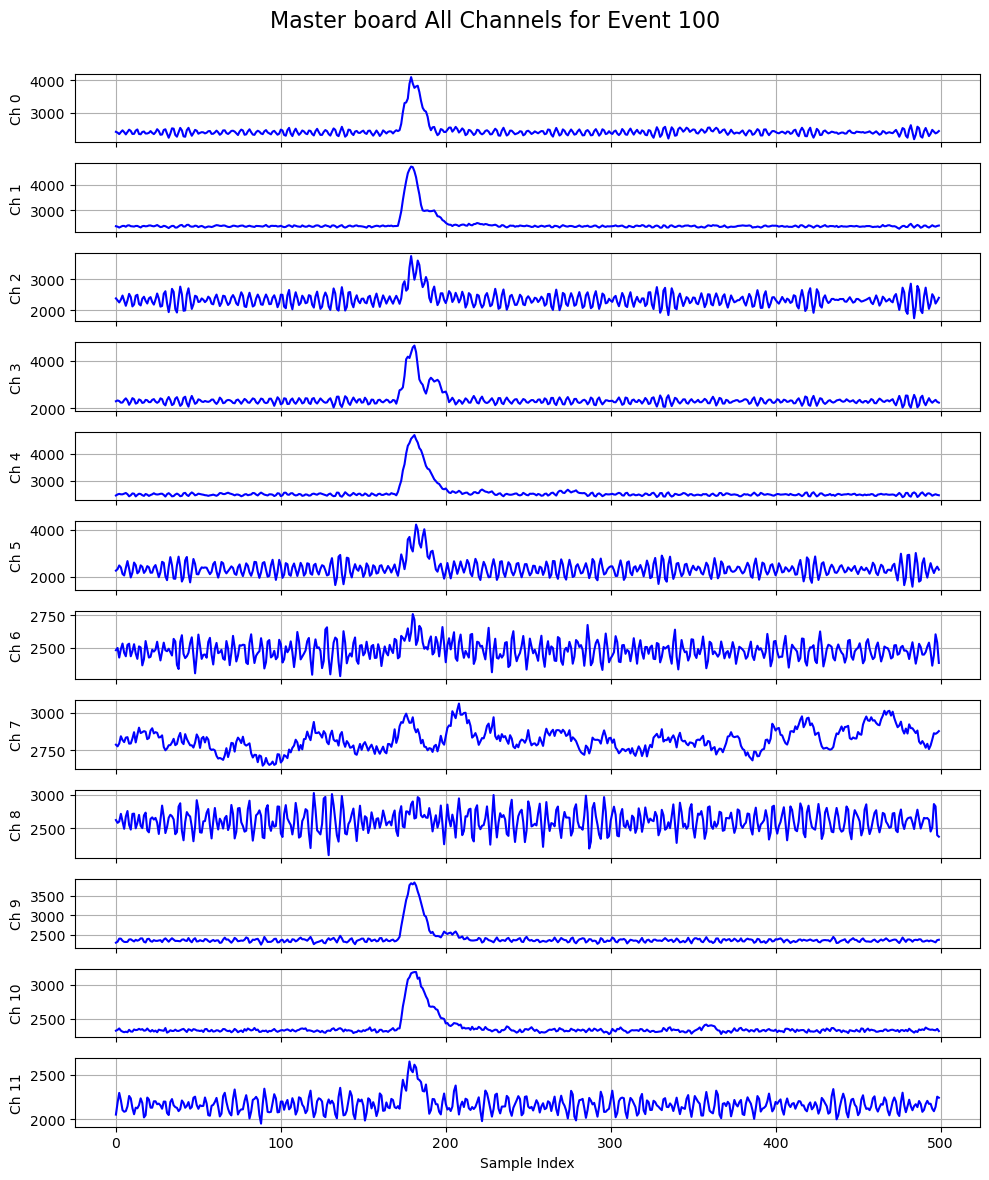

In [6]:
event_index0 = 100

# Extract waveform for this event (shape: 12, 500)
event_waveforms = events_0[event_index0]

# Time axis
time = np.arange(event_waveforms.shape[1])  # [0, 1, ..., 499]

# Create subplots: 12 rows, 1 column
fig, axes = plt.subplots(12, 1, figsize=(10, 12), sharex=True)

for channel in range(12):
    axes[channel].plot(time, event_waveforms[channel], color='blue')
    axes[channel].set_ylabel(f'Ch {channel}')
    axes[channel].grid(True)

axes[-1].set_xlabel('Sample Index')
fig.suptitle(f'Master board All Channels for Event {event_index0}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave room for the title
plt.show()


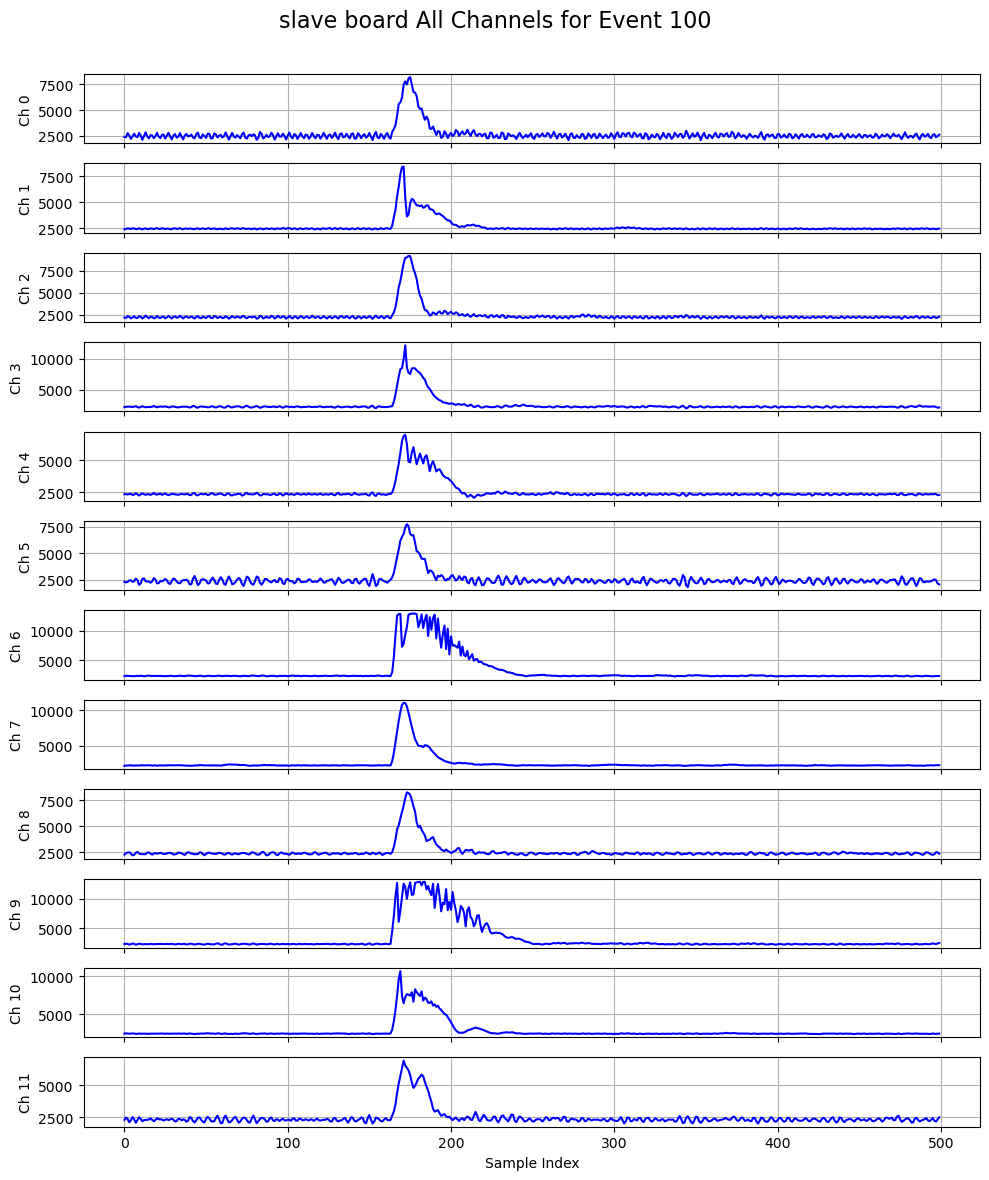

In [7]:
event_index1 = 100

# Extract waveform for this event (shape: 12, 500)
event_waveforms = events_1[event_index1]

# Time axis
time = np.arange(event_waveforms.shape[1])  # [0, 1, ..., 499]

# Create subplots: 12 rows, 1 column
fig, axes = plt.subplots(12, 1, figsize=(10, 12), sharex=True)

for channel in range(12):
    axes[channel].plot(time, event_waveforms[channel], color='blue')
    axes[channel].set_ylabel(f'Ch {channel}')
    axes[channel].grid(True)

axes[-1].set_xlabel('Sample Index')
fig.suptitle(f'slave board All Channels for Event {event_index1}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave room for the title
plt.show()

In [8]:
def N_e(dt):
    adc_resolution = 14
    V_ref = 2
    R = 50  # Ohm
    E = 1.6e-19
    dT = 4e-9  #ns


    # Convert to float voltage
    dt_in_volts = (dt / (2**adc_resolution - 1)) * V_ref
    # events_1_in_volts = (events_1.astype(np.float32) / (2**adc_resolution - 1)) * V_ref
    baseline_region = slice(0, 100)
    baseline = np.mean(dt_in_volts[:, :, baseline_region], axis=2)  # shape: (5713, 12)

    # Reshape baseline to allow broadcasting
    baseline_expanded = baseline[:, :, np.newaxis]  # shape: (5713, 12, 1)

    # Baseline-corrected waveforms
    corrected_waveforms = dt_in_volts - baseline_expanded

    # plt.plot(corrected_waveforms[808][0],label='Board [0]')
    # plt.show()


    # # Area under the curve
    # area_under_peaks = np.sum(corrected_waveforms, axis=2) * dT

    peak_window = slice(160, 210)
    area_under_peaks_windowed = np.sum(corrected_waveforms[:, :, peak_window], axis=2) * dT

    Ne = area_under_peaks_windowed/(R*E)

    return Ne

In [9]:
# Calculate the number of electrons for each event
Ne0 = N_e(events_0)
Ne1 = N_e(events_1)

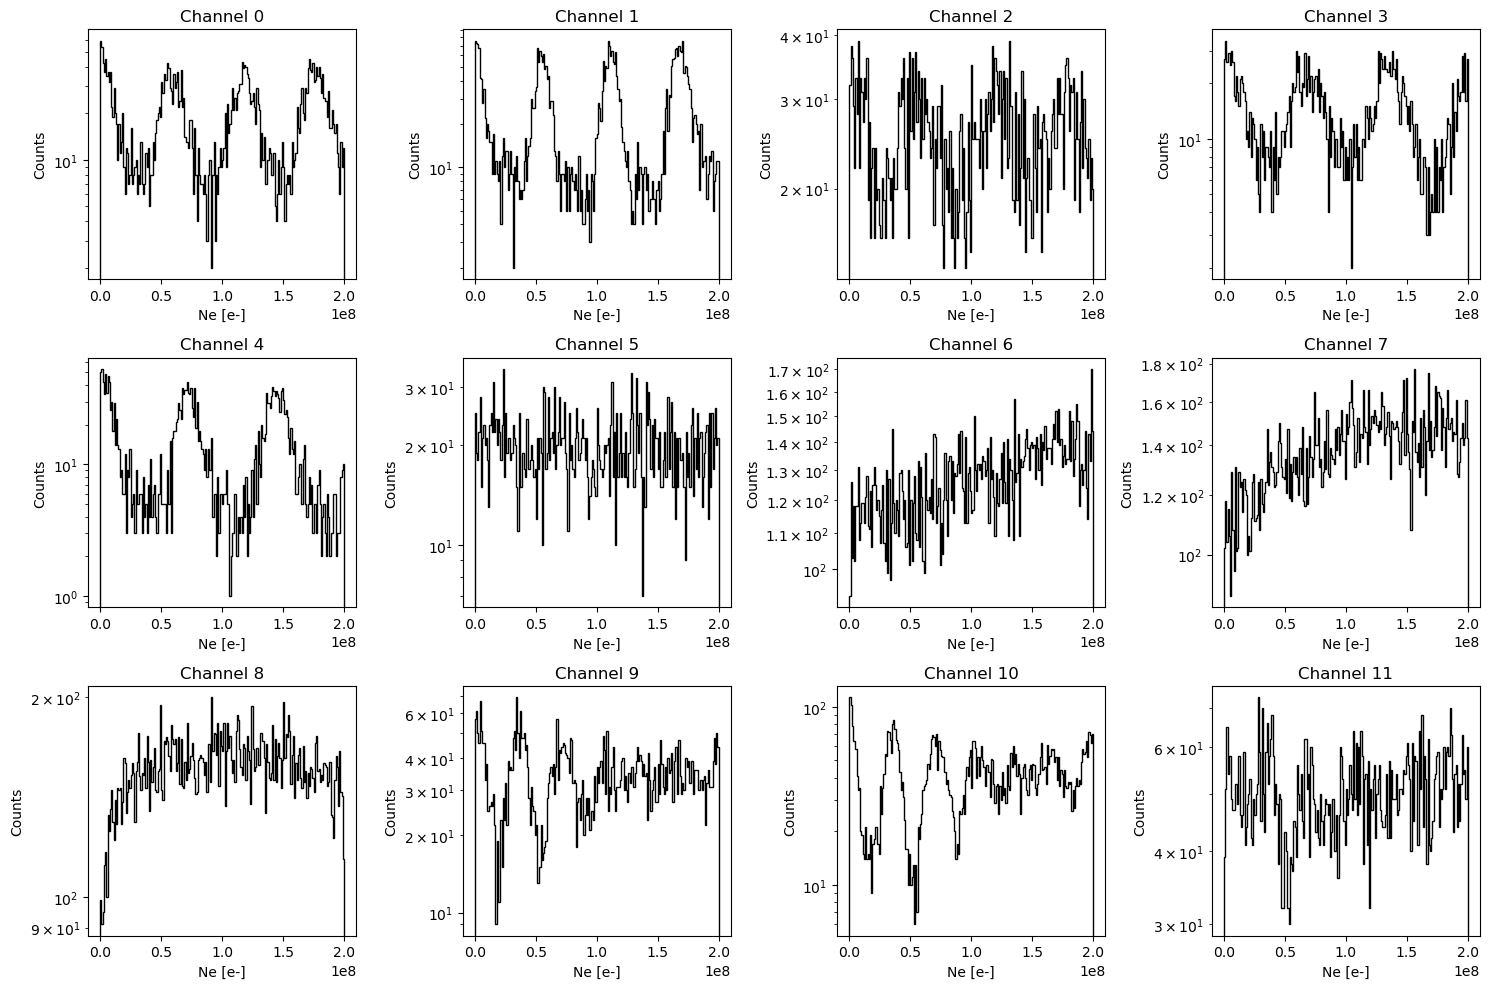

In [22]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 12 subplots (3 rows x 4 cols)

for ch in range(12):
    Ne0_spe_cut = (Ne0[:,ch]<2e8) & (Ne0[:,ch]>0)
    ax = axes[ch // 4, ch % 4]
    ax.hist(Ne0[:,ch][Ne0_spe_cut], bins=200, color='skyblue', edgecolor='black',histtype='step')
    ax.set_title(f'Channel {ch}')
    ax.set_xlabel('Ne [e-]')
    ax.set_ylabel('Counts')
    # ax.set_xlim(0, 1.5e11)
    ax.set_yscale('log')
plt.tight_layout()
plt.show()

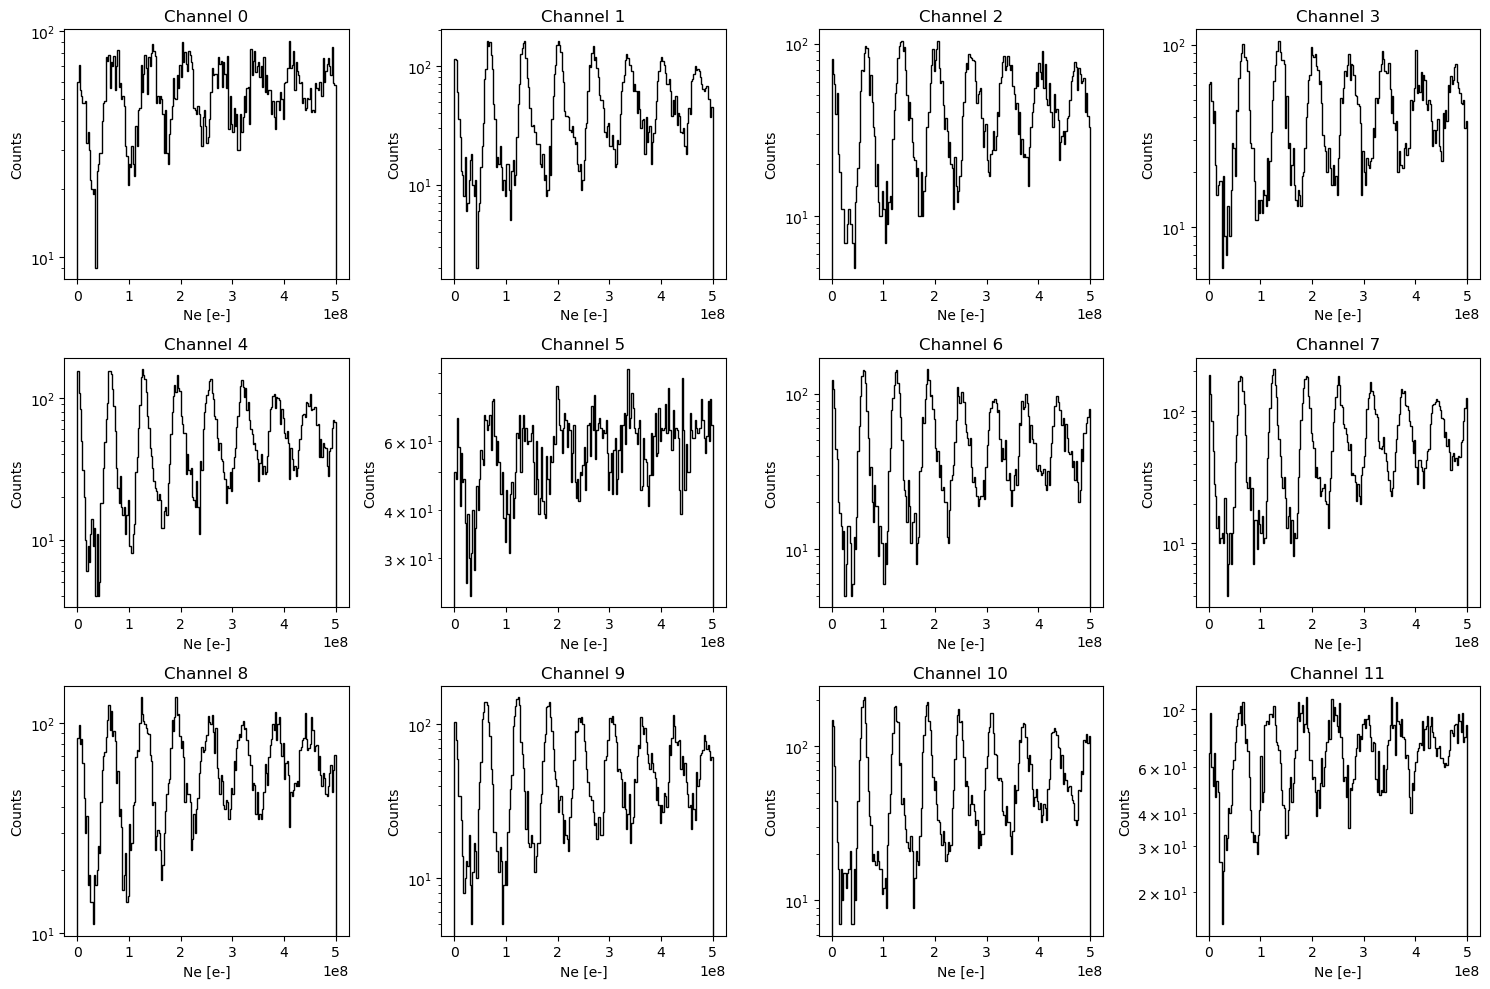

In [20]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 12 subplots (3 rows x 4 cols)

for ch in range(12):
    Ne1_spe_cut = (Ne1[:,ch]<5e8) & (Ne1[:,ch]>0)
    ax = axes[ch // 4, ch % 4]
    ax.hist(Ne1[:,ch][Ne1_spe_cut], bins=200, color='skyblue', edgecolor='black',histtype='step')
    ax.set_title(f'Channel {ch}')
    ax.set_xlabel('Ne [e-]')
    ax.set_ylabel('Counts')
    # ax.set_xlim(0, 1.5e11)
    ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [23]:
Ne0_ch0 = Ne0[:,0]
Ne0_ch1 = Ne0[:,1]

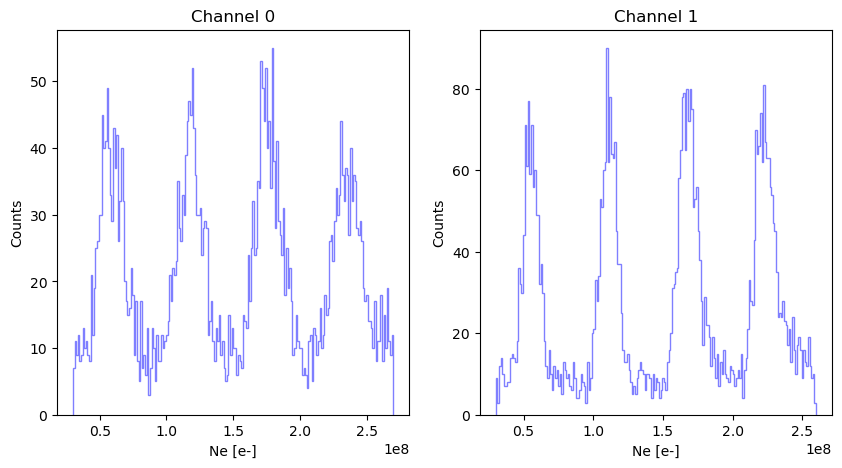

In [65]:
min0 = 2.7e8
max0 = 3e7
min1 = 2.6e8
max1 = 3e7
Ne0_ch0_spe_cut = (Ne0_ch0<min0) & (Ne0_ch0>max0)
Ne0_ch1_spe_cut = (Ne0_ch1<min1) & (Ne0_ch1>max1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
hist0 = ax[0].hist(Ne0_ch0[Ne0_ch0_spe_cut], bins=200, color='blue', alpha=0.5, label='Ch 0', histtype='step')
hist1 = ax[1].hist(Ne0_ch1[Ne0_ch1_spe_cut], bins=200, color='blue', alpha=0.5, label='Ch 1', histtype='step')
ax[0].set_title('Channel 0')
ax[1].set_title('Channel 1')
ax[0].set_xlabel('Ne [e-]')
ax[1].set_xlabel('Ne [e-]')
ax[0].set_ylabel('Counts')
ax[1].set_ylabel('Counts')
plt.show()

In [77]:
from scipy.optimize import curve_fit
def gaussian(x, amp, mean, stddev):
    return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

In [95]:
peaks0 = [(hist0[0][50*i:50*(i+1)], hist0[1][50*i:50*(i+1)+1]) for i in range(4)]
peaks1 = [(hist1[0][50*i:50*(i+1)], hist1[1][50*i:50*(i+1)+1]) for i in range(4)]

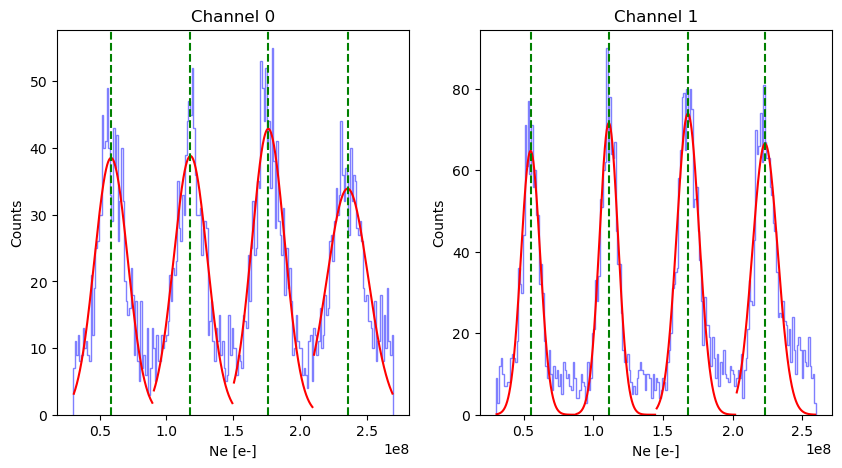

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(Ne0_ch0[Ne0_ch0_spe_cut], bins=200, color='blue', alpha=0.5, label='Ch 0', histtype='step')
ax[1].hist(Ne0_ch1[Ne0_ch1_spe_cut], bins=200, color='blue', alpha=0.5, label='Ch 1', histtype='step')
ax[0].set_title('Channel 0')
ax[1].set_title('Channel 1')
ax[0].set_xlabel('Ne [e-]')
ax[1].set_xlabel('Ne [e-]')
ax[0].set_ylabel('Counts')
ax[1].set_ylabel('Counts')

results0 = []
for peak in peaks0:
    bin_centers = 0.5 * (peak[1][:-1] + peak[1][1:])
    params, _ = curve_fit(gaussian, bin_centers, peak[0], p0=[50, np.mean(bin_centers), np.std(bin_centers)])
    x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
    y_fit = gaussian(x_fit, *params)
    ax[0].plot(x_fit, y_fit, color='red', label='Gaussian Fit')
    ax[0].axvline(params[1], color='green', linestyle='--', label='Mean Fit')
    results0.append(params[1])

results1 = []
for peak in peaks1:
    bin_centers = 0.5 * (peak[1][:-1] + peak[1][1:])
    params, _ = curve_fit(gaussian, bin_centers, peak[0], p0=[50, np.mean(bin_centers), np.std(bin_centers)])
    x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
    y_fit = gaussian(x_fit, *params)
    ax[1].plot(x_fit, y_fit, color='red', label='Gaussian Fit')
    ax[1].axvline(params[1], color='green', linestyle='--', label='Mean Fit')
    results1.append(params[1])

plt.show()
    

In [106]:
results0 = np.array(results0)
results1 = np.array(results1)
gain0 = np.mean(results0[1:] - results0[:-1])
gain1 = np.mean(results1[1:] - results1[:-1])

In [107]:
print(gain0, gain1)

59061867.13729233 56099439.259616405
